In [1]:
import sys
import pickle
sys.path.append('../..')
import pandas as pd
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, transf_chik_pred
from pgbm_model import  cross_dengue_chik_prediction
import matplotlib.dates as mdates
from plots_pgbm import predicted_vs_observed as p_o_pgbm
from plots_lstm import predicted_vs_observed as p_o_lstm
fmt = mdates.DateFormatter('%d-%b\n%Y')

In [2]:
CITY = 2611606
CITY_NAME = 'Recife'
STATE = 'PE'
FILENAME_DATA = f'../../data/chik_{CITY}_cluster.csv'

In [3]:
df_chik = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_2614857,casos_est_2614857,casos_est_min_2614857,casos_est_max_2614857,p_rt1_2614857,p_inc100k_2614857,temp_min_2614857,temp_max_2614857,umid_min_2614857,pressao_min_2614857,...,casos_2613800,casos_est_2613800,casos_est_min_2613800,casos_est_max_2613800,p_rt1_2613800,p_inc100k_2613800,temp_min_2613800,temp_max_2613800,umid_min_2613800,pressao_min_2613800
2010-01-03,0,0.0,0,0,0.000000,0.00000,21.666667,29.666667,54.333333,1010.666667,...,0,0.0,0,0,0.000000,0.00000,22.666667,31.333333,48.000000,1010.666667
2010-01-10,0,0.0,0,0,0.000000,0.00000,22.000000,29.428571,53.142857,1010.714286,...,0,0.0,0,0,0.000000,0.00000,22.000000,30.857143,46.571429,1011.000000
2010-01-17,0,0.0,0,0,0.000000,0.00000,22.714286,29.857143,55.142857,1012.428571,...,0,0.0,0,0,0.000000,0.00000,22.142857,30.571429,46.857143,1012.714286
2010-01-24,0,0.0,0,0,0.000000,0.00000,21.142857,27.571429,62.142857,1011.285714,...,0,0.0,0,0,0.000000,0.00000,21.714286,30.285714,48.142857,1011.571429
2010-01-31,0,0.0,0,0,0.000000,0.00000,23.000000,30.000000,58.142857,1010.142857,...,0,0.0,0,0,0.000000,0.00000,22.428571,31.142857,49.000000,1010.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-29,0,0.0,0,0,0.000000,0.00000,21.857143,27.000000,71.480471,1014.142857,...,11,11.0,11,14,0.232316,60.82390,20.285714,25.428571,76.269171,1015.000000
2022-06-05,2,2.0,2,2,0.921897,8.46632,22.142857,27.000000,74.248829,1011.857143,...,0,0.0,0,3,0.000000,0.00000,20.857143,26.142857,74.331671,1013.000000
2022-06-12,1,1.0,1,1,0.663458,4.23316,21.714286,26.285714,74.289157,1013.142857,...,1,1.0,1,5,0.003296,5.52944,20.000000,24.714286,76.677300,1014.142857
2022-06-19,0,0.0,0,0,0.000000,0.00000,21.571429,25.571429,74.774829,1014.428571,...,0,0.0,0,7,0.000000,0.00000,20.000000,26.000000,71.428271,1015.428571


<AxesSubplot:>

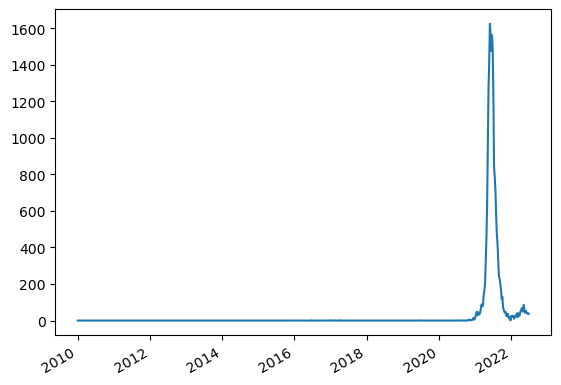

In [4]:
df_chik[f'casos_est_{CITY}'].plot()

In [5]:
INI_DATE = '2021-01-01'
END_DATE = '2022-01-01'

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = df_chik.shape[1] +1 # number of features 

Apply the dengue model:

2023-01-17 11:41:55.437877: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


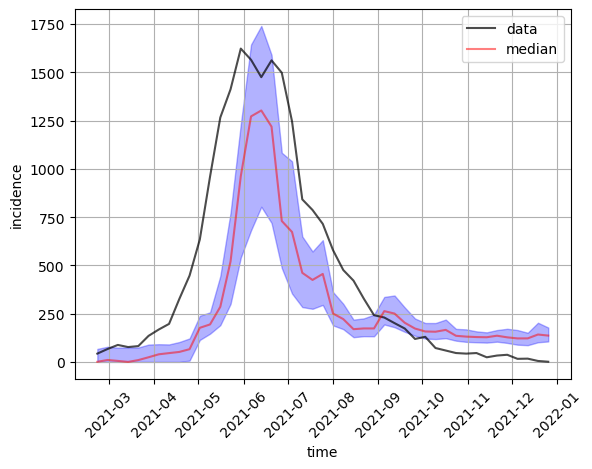

In [6]:
metrics = apply_dengue_chik(CITY, ini_date = INI_DATE, 
                         end_date = END_DATE, look_back = LOOK_BACK,
                         predict_n = PREDICT_N,  label_m = f'msle_all', filename = FILENAME_DATA )

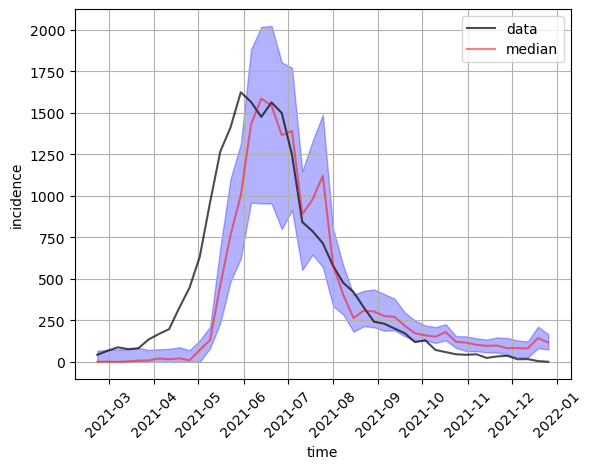

In [7]:
metrics = apply_dengue_chik(CITY, ini_date = INI_DATE, 
                         end_date = END_DATE, look_back = LOOK_BACK,
                         predict_n = PREDICT_N,  label_m = f'custom_msle_all', filename = FILENAME_DATA )

Applying the **transfer learning** techinique:

- Using the model trained with `loss = 'msle'`:


Compilation Time :  0.002753019332885742
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 131)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             8960      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0

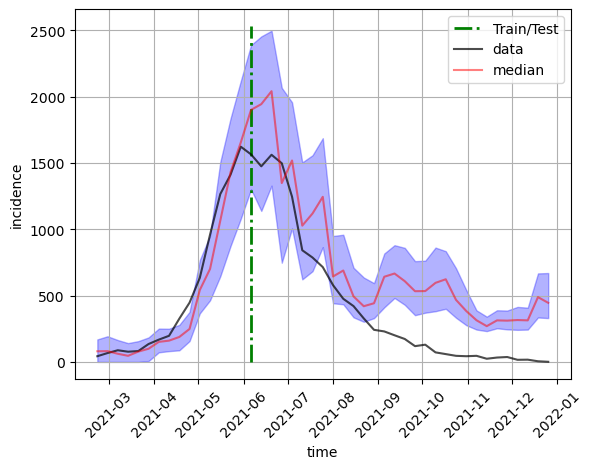

In [8]:

END_DATE_TRAIN = f'2021-06-01'

model = build_model(hidden = 8, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

    
m_msle, m_t, m_val = transf_chik_pred(model, CITY, ini_date = INI_DATE, end_train_date = END_DATE_TRAIN,  
                                end_date = END_DATE, filename = f'../../saved_models/lstm/trained_{CITY}_model_msle_all.h5',  epochs= EPOCHS, features = FEAT,  
                                predict_n = PREDICT_N, look_back = LOOK_BACK, loss = 'msle' , validation_split = 0.0,
                                label = f'transf_msle', filename_data = FILENAME_DATA)

Compilation Time :  0.0015673637390136719
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 131)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             8960      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)               

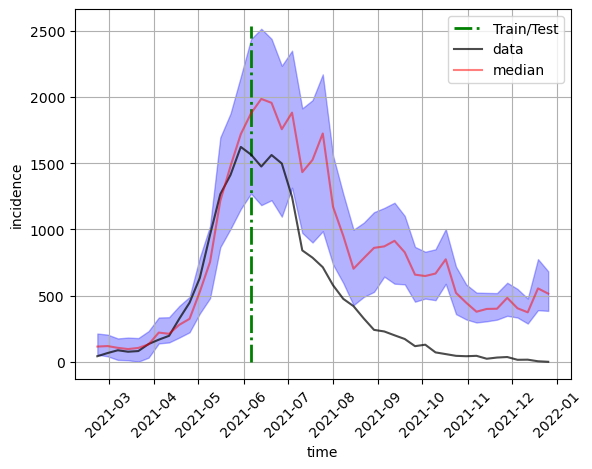

In [9]:
from lstm import custom_loss_msle

model = build_model(hidden = 8, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = custom_loss_msle(p=10))

    
m_msle, m_t, m_val = transf_chik_pred(model, CITY, ini_date = INI_DATE, end_train_date = END_DATE_TRAIN,  
                                end_date = END_DATE, filename = f'../../saved_models/lstm/trained_{CITY}_model_custom_msle_all.h5',  epochs= EPOCHS, features = FEAT,  
                                predict_n = PREDICT_N, look_back = LOOK_BACK, loss = custom_loss_msle(p=10) , validation_split = 0.0,
                                label = f'transf_custom_msle', filename_data = FILENAME_DATA)

Apply the pgbm model:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


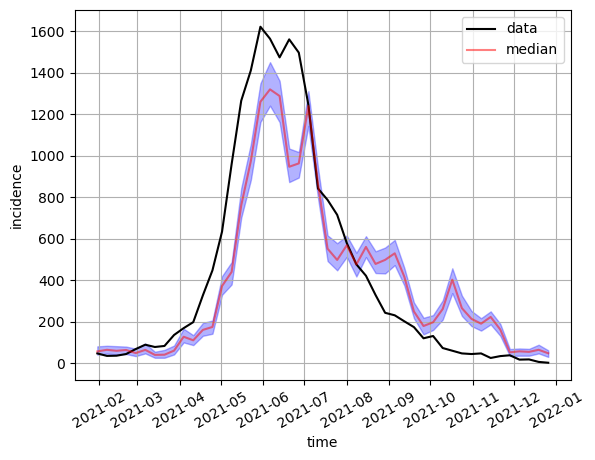

In [10]:
preds, preds25, preds975, X_data, targets = cross_dengue_chik_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK, ini_date = INI_DATE, end_date = END_DATE, filename = FILENAME_DATA)
    